In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import scipy.signal as sp
import datetime as dt
from beam2ENU import beam2ENU
import seawater as sw
import oceans as oc
from scipy.interpolate import griddata


In [77]:
directory = '../../Data/deployment_raw/';
outdir = '../../plots/Ri/Ri_profile/';
deployment_name = 'deploy1_';
measurement_type = 'ctd_';
file_type = 'raw_'
grid = pd.DataFrame(columns=['N2','shr2','Ri']) # Note that there are now row data inserted.

In [78]:
def create_data(directory, c_file, a_file):
    #Open the CTD data file that has all data stored as pandas
    c_data = pd.read_pickle(directory+deployment_name+file_type+c_file)
    a_data = pd.read_pickle(directory+deployment_name+file_type+a_file)

    #Join CTD and ADCP data together (add time to CTD data)
    start_time = a_data["a_time"].values[1][:-10]
    start_time = dt.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
    start_time = start_time - dt.timedelta(seconds=15)
    c_data["c_time"] = [start_time+dt.timedelta(seconds=x) for x in range(len(c_data["c_temp"].values))]
    c_data.index = pd.DatetimeIndex(c_data['c_time'])

    #And average ADCP to resample at 1Hz
    a_data.index = pd.DatetimeIndex(a_data['a_time'])
    a_data = a_data.resample('S').mean()
    #Combine both datasets into one dataset by time
    data = pd.concat([a_data, c_data], axis=1, sort=False).dropna(axis='rows')
    data_start = data.index[data["c_pres"]>20][0]
    data_end = data.index[data["c_pres"]>100][0]
    data = data[data_start:data_end]
    return data

In [79]:
# def buoyancy_freq(data):
#     #Get buoyancy frequency
#     CT = gsw.CT_from_t(data['c_sal'],data['c_temp'],data['c_pres'])
#     SA = gsw.SA_from_SP(data['c_sal'],data['c_pres'],174,-43)
#     [N2,p_mid,dp] = gsw.Nsquared(SA,CT,data['c_pres'])
#     #[n2,q,p_ave] = sw.bfrq(data['c_sal'],data['c_temp'],data['c_pres'],-43)
#     #N2 = [item[0] for item in n2]
#     N2 = np.array(N2)
#     data['N2'] = np.append(N2,N2[-1])

#     #filter buoyancy frequency by removing outliers
#     data['N2'] = data["N2"].replace([np.inf, -np.inf], np.nan)
#     data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
#     data['N2'] = data['N2'].interpolate().rolling(10).mean().abs()
#     #data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > 3*data['N2'].std()))
#     #data['N2'] = data['N2'].interpolate()
#     #plt.plot(data['N2'])
#     #plt.show()
#     return data
def buoyancy_freq(data):
    #Get buoyancy frequency
    dp = np.diff(data['c_pres'].values,axis=0)
    data['dp'] = np.append(dp,dp[-1])
    data['dp'] = data['dp'].mask(((data['dp']-data['dp'].mean()).abs() > data['dp'].std()))
    data['dp'] = data['dp'].interpolate().rolling(5).mean()
    CT = gsw.CT_from_t(data['c_sal'],data['c_temp'],data['c_pres'])
    SA = gsw.SA_from_SP(data['c_sal'],data['c_pres'],174,-43)
    pdens = gsw.sigma0(SA, CT)
    data['pdens'] = pdens
    dpdens = np.diff(data['pdens'].values,axis=0)
    data['dpdens'] = np.append(dpdens,dpdens[-1])
    data['dpdens'] = data['dpdens'].mask(((data['dpdens']-data['dpdens'].mean()).abs() > data['dpdens'].std()))
    data['dpdens'] = data['dpdens'].interpolate().rolling(5).mean()    
    data['N2'] = (9.7963*data['dpdens'])/(data['pdens']*data['dp'])

    
    
    #filter buoyancy frequency by removing outliers
    #data['N2'] = data['N2'].mask(data['N2']< 0.000005)
    data['N2'] = data["N2"].replace([np.inf, -np.inf], np.nan)
    data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
    data['N2'] = data['N2'].interpolate().rolling(10).mean()
    #data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > 3*data['N2'].std()))
    #data['N2'] = data['N2'].interpolate()
    
    #Sorted
    data['pdens_sort'] = np.sort(pdens)
    dpdens_sort = np.diff(data['pdens_sort'].values,axis=0)
    data['dpdens_sort'] = np.append(dpdens_sort,dpdens_sort[-1])
    data['dpdens_sort'] = data['dpdens_sort'].mask(((data['dpdens_sort']-data['dpdens_sort'].mean()).abs() > data['dpdens_sort'].std()))
    data['dpdens_sort'] = data['dpdens_sort'].interpolate().rolling(5).mean()    
    data['N2_sort'] = (9.7963*data['dpdens_sort'])/(data['pdens_sort']*data['dp'])   
    print(data['N2_sort'])
    
    return data

In [80]:
def shear_mag(data):
    [east,north,up] = beam2ENU([data["a_beam1"][0],data["a_beam2"][0],data["a_beam3"][0],data["a_beam4"][0]],data['a_heading'].values,data['a_pitch'].values,data['a_roll'].values,data['a_vel1'].values,data['a_vel2'].values,data['a_vel3'].values)
    dp = np.diff(data['c_pres'].values,axis=0)
    data['dp'] = np.append(dp,dp[-1]) 
    data['dp'] = data['dp'].mask(((data['dp']-data['dp'].mean()).abs() > data['dp'].std()))
    data['dp'] = data['dp'].interpolate().rolling(10).mean()
    deast = np.diff(east,axis=0) 
    data['dV'] = np.append(deast,deast[-1]) 
    data['dV'] = data['dV'].mask(((data['dV']-data['dV'].mean()).abs() > data['dV'].std()))
    data['dV'] = data['dV'].interpolate().rolling(10).mean()
    dnorth = np.diff(north,axis=0) 
    data['dU'] = np.append(dnorth,dnorth[-1])
    data['dU'] = data['dU'].mask(((data['dU']-data['dU'].mean()).abs() > data['dU'].std()))
    data['dU'] = data['dU'].interpolate().rolling(10).mean()
    data['S2'] = (data['dU']/data['dp'])**2 + (data['dV']/data['dp'])**2
    #data['S2'] = (data['dV']/data['dp'])**2

    #data['S2'] = data['S2'].mask(data['S2']> 0.02)
    #data['S2'] = data['S2'].mask(data['S2']< 0.0005)
    data['S2'] = data['S2'].mask(((data['S2']-data['S2'].mean()).abs() > data['S2'].std()))
    data['S2'] = data['S2'].interpolate().rolling(10).mean()
    return data

In [81]:
def richardson_num(data):
    #Make Richardson number 
    data['Ri'] = data['N2']/data['S2']
    data['Ri_sort'] = data['N2_sort']/data['S2']
    #data['Ri'] = data['Ri'].mask(data['Ri'] > 1)
    #data['Ri'] = data['Ri'].mask(data['Ri'] < -1)
    data['Ri'] = data['Ri'].mask(((data['Ri']-data['Ri'].mean()).abs() > data['Ri'].std()))
    data['Ri'] = data['Ri'].interpolate().rolling(5).mean()
    
    data['Ri_sort'] = data['Ri_sort'].mask(((data['Ri_sort']-data['Ri_sort'].mean()).abs() > data['Ri_sort'].std()))
    data['Ri_sort'] = data['Ri_sort'].interpolate().rolling(5).mean()
    return data

In [82]:
reject = 0
for profile in range(0,58,2):
    c_file = 'C'+("%07d" % (profile,))
    a_file = 'A'+("%07d" % (profile,))
    
    data = create_data(directory, c_file, a_file)
    data = buoyancy_freq(data)
    data = shear_mag(data)
    data = richardson_num(data)
    
#     #data binned by 1 meter
#     ttitle = "1 meter bins"
#     data['c_depth'] = data['c_depth'].round(0)
#     data = data.groupby(data['c_depth']).mean()
#     data['profile'] = [profile]*len(data)
    
    #data binned by other meter
    ttitle = "10.25 meter bins"
    #data['c_depth'] = data['c_depth']/4
    data['c_depth'] = data['c_depth'].round(0)
    data = data.groupby(data['c_depth']).mean()
    #data['c_depth'] = data['c_depth']*4
    
    
    #if profile not in [6,12,16,28,34,48,56]:
    #    grid = pd.concat([grid,data])
    if profile == 48:
        reject += 2
    if profile not in [48]:
        data['profile'] = [profile-reject]*len(data)
        grid = pd.concat([grid,data])
    #grid = pd.concat([grid,data])

2018-06-09 02:07:27         NaN
2018-06-09 02:07:28         NaN
2018-06-09 02:07:29         NaN
2018-06-09 02:07:30         NaN
2018-06-09 02:07:31         NaN
2018-06-09 02:07:32         NaN
2018-06-09 02:07:33         NaN
2018-06-09 02:07:34         NaN
2018-06-09 02:07:35    0.000785
2018-06-09 02:07:36    0.000865
2018-06-09 02:07:37    0.000808
2018-06-09 02:07:38    0.000880
2018-06-09 02:07:39    0.000910
2018-06-09 02:07:40    0.001087
2018-06-09 02:07:41    0.001041
2018-06-09 02:07:42    0.001109
2018-06-09 02:07:43    0.000886
2018-06-09 02:07:44    0.000672
2018-06-09 02:07:45    0.000547
2018-06-09 02:07:46    0.000352
2018-06-09 02:07:47    0.000324
2018-06-09 02:07:48    0.000439
2018-06-09 02:07:49    0.000477
2018-06-09 02:07:50    0.000475
2018-06-09 02:07:51    0.000635
2018-06-09 02:07:52    0.000762
2018-06-09 02:07:53    0.000769
2018-06-09 02:07:54    0.000799
2018-06-09 02:07:55    0.000832
2018-06-09 02:07:56    0.001062
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 02:43:24         NaN
2018-06-09 02:43:25         NaN
2018-06-09 02:43:26         NaN
2018-06-09 02:43:27         NaN
2018-06-09 02:43:28    0.000474
2018-06-09 02:43:29    0.000354
2018-06-09 02:43:30    0.000240
2018-06-09 02:43:31    0.000181
2018-06-09 02:43:32    0.000242
2018-06-09 02:43:33    0.000224
2018-06-09 02:43:34    0.000382
2018-06-09 02:43:35    0.000612
2018-06-09 02:43:36    0.000744
2018-06-09 02:43:37    0.000592
2018-06-09 02:43:38    0.000762
2018-06-09 02:43:39    0.000597
2018-06-09 02:43:40    0.000412
2018-06-09 02:43:41    0.000338
2018-06-09 02:43:42    0.000549
2018-06-09 02:43:43    0.000502
2018-06-09 02:43:44    0.000667
2018-06-09 02:43:45    0.000759
2018-06-09 02:43:46    0.000933
2018-06-09 02:43:47    0.000701
2018-06-09 02:43:48    0.000453
2018-06-09 02:43:49    0.000415
2018-06-09 02:43:50    0.000564
2018-06-09 02:43:51    0.000405
2018-06-09 02:43:52    0.000311
2018-06-09 02:43:53    0.000307
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 03:19:05         NaN
2018-06-09 03:19:06         NaN
2018-06-09 03:19:07         NaN
2018-06-09 03:19:08         NaN
2018-06-09 03:19:09         NaN
2018-06-09 03:19:10    0.000424
2018-06-09 03:19:11    0.000389
2018-06-09 03:19:12    0.000416
2018-06-09 03:19:13    0.000366
2018-06-09 03:19:14    0.000295
2018-06-09 03:19:15    0.000277
2018-06-09 03:19:16    0.000248
2018-06-09 03:19:17    0.000298
2018-06-09 03:19:18    0.000309
2018-06-09 03:19:19    0.000350
2018-06-09 03:19:20    0.000345
2018-06-09 03:19:21    0.000422
2018-06-09 03:19:22    0.000417
2018-06-09 03:19:23    0.000562
2018-06-09 03:19:24    0.000566
2018-06-09 03:19:25    0.000624
2018-06-09 03:19:26    0.000549
2018-06-09 03:19:27    0.000359
2018-06-09 03:19:28    0.000158
2018-06-09 03:19:29    0.000135
2018-06-09 03:19:30    0.000252
2018-06-09 03:19:31    0.000423
2018-06-09 03:19:32    0.000670
2018-06-09 03:19:33    0.001016
2018-06-09 03:19:34    0.001582
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 03:54:38         NaN
2018-06-09 03:54:39         NaN
2018-06-09 03:54:40         NaN
2018-06-09 03:54:41         NaN
2018-06-09 03:54:42    0.000545
2018-06-09 03:54:43    0.000326
2018-06-09 03:54:44    0.000468
2018-06-09 03:54:45    0.000556
2018-06-09 03:54:46    0.000474
2018-06-09 03:54:47    0.000377
2018-06-09 03:54:48    0.000483
2018-06-09 03:54:49    0.000479
2018-06-09 03:54:50    0.000340
2018-06-09 03:54:51    0.000365
2018-06-09 03:54:52    0.000479
2018-06-09 03:54:53    0.000532
2018-06-09 03:54:54    0.000635
2018-06-09 03:54:55    0.000834
2018-06-09 03:54:56    0.000896
2018-06-09 03:54:57    0.000778
2018-06-09 03:54:58    0.000738
2018-06-09 03:54:59    0.000808
2018-06-09 03:55:00    0.000842
2018-06-09 03:55:01    0.000881
2018-06-09 03:55:02    0.001252
2018-06-09 03:55:03    0.001053
2018-06-09 03:55:04    0.000735
2018-06-09 03:55:05    0.000494
2018-06-09 03:55:06    0.000373
2018-06-09 03:55:07    0.000225
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 04:30:40         NaN
2018-06-09 04:30:41         NaN
2018-06-09 04:30:42         NaN
2018-06-09 04:30:43         NaN
2018-06-09 04:30:44         NaN
2018-06-09 04:30:45    0.000457
2018-06-09 04:30:46    0.000399
2018-06-09 04:30:47    0.000453
2018-06-09 04:30:48    0.000613
2018-06-09 04:30:49    0.000852
2018-06-09 04:30:50    0.000971
2018-06-09 04:30:51    0.001131
2018-06-09 04:30:52    0.001002
2018-06-09 04:30:53    0.000815
2018-06-09 04:30:54    0.000750
2018-06-09 04:30:55    0.000594
2018-06-09 04:30:56    0.000514
2018-06-09 04:30:57    0.000684
2018-06-09 04:30:58    0.000668
2018-06-09 04:30:59    0.000671
2018-06-09 04:31:00    0.000714
2018-06-09 04:31:01    0.000631
2018-06-09 04:31:02    0.000638
2018-06-09 04:31:03    0.000710
2018-06-09 04:31:04    0.000590
2018-06-09 04:31:05    0.000549
2018-06-09 04:31:06    0.000638
2018-06-09 04:31:07    0.000473
2018-06-09 04:31:08    0.000429
2018-06-09 04:31:09    0.000375
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 05:06:31         NaN
2018-06-09 05:06:32         NaN
2018-06-09 05:06:33         NaN
2018-06-09 05:06:34         NaN
2018-06-09 05:06:35    0.000987
2018-06-09 05:06:36    0.000850
2018-06-09 05:06:37    0.000656
2018-06-09 05:06:38    0.000646
2018-06-09 05:06:39    0.000879
2018-06-09 05:06:40    0.001223
2018-06-09 05:06:41    0.001295
2018-06-09 05:06:42    0.001479
2018-06-09 05:06:43    0.001644
2018-06-09 05:06:44    0.001430
2018-06-09 05:06:45    0.001136
2018-06-09 05:06:46    0.001104
2018-06-09 05:06:47    0.000820
2018-06-09 05:06:48    0.000563
2018-06-09 05:06:49    0.000560
2018-06-09 05:06:50    0.000545
2018-06-09 05:06:51    0.000401
2018-06-09 05:06:52    0.000510
2018-06-09 05:06:53    0.000511
2018-06-09 05:06:54    0.000611
2018-06-09 05:06:55    0.000926
2018-06-09 05:06:56    0.000973
2018-06-09 05:06:57    0.001009
2018-06-09 05:06:58    0.000811
2018-06-09 05:06:59    0.000605
2018-06-09 05:07:00    0.000197
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 05:41:56         NaN
2018-06-09 05:41:57         NaN
2018-06-09 05:41:58         NaN
2018-06-09 05:41:59         NaN
2018-06-09 05:42:00         NaN
2018-06-09 05:42:01         NaN
2018-06-09 05:42:02         NaN
2018-06-09 05:42:03    0.002307
2018-06-09 05:42:04    0.002075
2018-06-09 05:42:05    0.002195
2018-06-09 05:42:06    0.002341
2018-06-09 05:42:07    0.002329
2018-06-09 05:42:08    0.002575
2018-06-09 05:42:09    0.002234
2018-06-09 05:42:10    0.002019
2018-06-09 05:42:11    0.001745
2018-06-09 05:42:12    0.001548
2018-06-09 05:42:13    0.001310
2018-06-09 05:42:14    0.001446
2018-06-09 05:42:15    0.001882
2018-06-09 05:42:16    0.002253
2018-06-09 05:42:17    0.002596
2018-06-09 05:42:18    0.002785
2018-06-09 05:42:19    0.003415
2018-06-09 05:42:20    0.002976
2018-06-09 05:42:21    0.003402
2018-06-09 05:42:22    0.002836
2018-06-09 05:42:23    0.002323
2018-06-09 05:42:24    0.001823
2018-06-09 05:42:25    0.001887
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 06:17:29         NaN
2018-06-09 06:17:30         NaN
2018-06-09 06:17:31         NaN
2018-06-09 06:17:32         NaN
2018-06-09 06:17:33    0.001799
2018-06-09 06:17:34    0.001588
2018-06-09 06:17:35    0.001859
2018-06-09 06:17:36    0.002180
2018-06-09 06:17:37    0.002600
2018-06-09 06:17:38    0.002656
2018-06-09 06:17:39    0.002499
2018-06-09 06:17:40    0.002101
2018-06-09 06:17:41    0.001494
2018-06-09 06:17:42    0.001195
2018-06-09 06:17:43    0.001443
2018-06-09 06:17:44    0.001675
2018-06-09 06:17:45    0.001894
2018-06-09 06:17:46    0.002159
2018-06-09 06:17:47    0.002277
2018-06-09 06:17:48    0.001953
2018-06-09 06:17:49    0.001714
2018-06-09 06:17:50    0.001626
2018-06-09 06:17:51    0.001844
2018-06-09 06:17:52    0.002005
2018-06-09 06:17:53    0.002089
2018-06-09 06:17:54    0.002062
2018-06-09 06:17:55    0.001900
2018-06-09 06:17:56    0.001273
2018-06-09 06:17:57    0.001331
2018-06-09 06:17:58    0.001437
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 06:52:21         NaN
2018-06-09 06:52:22         NaN
2018-06-09 06:52:23         NaN
2018-06-09 06:52:24         NaN
2018-06-09 06:52:25         NaN
2018-06-09 06:52:26         NaN
2018-06-09 06:52:27         NaN
2018-06-09 06:52:28    0.001057
2018-06-09 06:52:29    0.001646
2018-06-09 06:52:30    0.002013
2018-06-09 06:52:31    0.002340
2018-06-09 06:52:32    0.002725
2018-06-09 06:52:33    0.002703
2018-06-09 06:52:34    0.002835
2018-06-09 06:52:35    0.003223
2018-06-09 06:52:36    0.002720
2018-06-09 06:52:37    0.002639
2018-06-09 06:52:38    0.002773
2018-06-09 06:52:39    0.002890
2018-06-09 06:52:40    0.002295
2018-06-09 06:52:41    0.002390
2018-06-09 06:52:42    0.001907
2018-06-09 06:52:43    0.001491
2018-06-09 06:52:44    0.000753
2018-06-09 06:52:45    0.000508
2018-06-09 06:52:46    0.000369
2018-06-09 06:52:47    0.000318
2018-06-09 06:52:48    0.000256
2018-06-09 06:52:49    0.000232
2018-06-09 06:52:50    0.000204
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 07:26:07         NaN
2018-06-09 07:26:08         NaN
2018-06-09 07:26:09         NaN
2018-06-09 07:26:10         NaN
2018-06-09 07:26:11         NaN
2018-06-09 07:26:12         NaN
2018-06-09 07:26:13         NaN
2018-06-09 07:26:14    0.002275
2018-06-09 07:26:15    0.002527
2018-06-09 07:26:16    0.002077
2018-06-09 07:26:17    0.001732
2018-06-09 07:26:18    0.001304
2018-06-09 07:26:19    0.001901
2018-06-09 07:26:20    0.002417
2018-06-09 07:26:21    0.002108
2018-06-09 07:26:22    0.002117
2018-06-09 07:26:23    0.002496
2018-06-09 07:26:24    0.002165
2018-06-09 07:26:25    0.002321
2018-06-09 07:26:26    0.002592
2018-06-09 07:26:27    0.002383
2018-06-09 07:26:28    0.001685
2018-06-09 07:26:29    0.001421
2018-06-09 07:26:30    0.001284
2018-06-09 07:26:31    0.001035
2018-06-09 07:26:32    0.000872
2018-06-09 07:26:33    0.001205
2018-06-09 07:26:34    0.001815
2018-06-09 07:26:35    0.001030
2018-06-09 07:26:36    0.001100
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 07:59:51         NaN
2018-06-09 07:59:52         NaN
2018-06-09 07:59:53         NaN
2018-06-09 07:59:54         NaN
2018-06-09 07:59:55         NaN
2018-06-09 07:59:56    0.002278
2018-06-09 07:59:57    0.001803
2018-06-09 07:59:58    0.001355
2018-06-09 07:59:59    0.001070
2018-06-09 08:00:00    0.000774
2018-06-09 08:00:01    0.000549
2018-06-09 08:00:02    0.000372
2018-06-09 08:00:03    0.000549
2018-06-09 08:00:04    0.000907
2018-06-09 08:00:05    0.001126
2018-06-09 08:00:06    0.001200
2018-06-09 08:00:07    0.001130
2018-06-09 08:00:08    0.001306
2018-06-09 08:00:09    0.001493
2018-06-09 08:00:10    0.001877
2018-06-09 08:00:11    0.002209
2018-06-09 08:00:12    0.002566
2018-06-09 08:00:13    0.002778
2018-06-09 08:00:14    0.002550
2018-06-09 08:00:15    0.002173
2018-06-09 08:00:16    0.001443
2018-06-09 08:00:17    0.001174
2018-06-09 08:00:18    0.000721
2018-06-09 08:00:19    0.000812
2018-06-09 08:00:20    0.000926
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 08:34:03         NaN
2018-06-09 08:34:04         NaN
2018-06-09 08:34:05         NaN
2018-06-09 08:34:06         NaN
2018-06-09 08:34:07    0.002539
2018-06-09 08:34:08    0.002547
2018-06-09 08:34:09    0.003149
2018-06-09 08:34:10    0.003313
2018-06-09 08:34:11    0.003716
2018-06-09 08:34:12    0.003730
2018-06-09 08:34:13    0.003723
2018-06-09 08:34:14    0.003485
2018-06-09 08:34:15    0.004228
2018-06-09 08:34:16    0.003824
2018-06-09 08:34:17    0.003277
2018-06-09 08:34:18    0.002761
2018-06-09 08:34:19    0.002510
2018-06-09 08:34:20    0.002026
2018-06-09 08:34:21    0.001453
2018-06-09 08:34:22    0.001776
2018-06-09 08:34:23    0.002313
2018-06-09 08:34:24    0.002628
2018-06-09 08:34:25    0.003314
2018-06-09 08:34:26    0.004323
2018-06-09 08:34:27    0.004806
2018-06-09 08:34:28    0.003924
2018-06-09 08:34:29    0.003050
2018-06-09 08:34:30    0.002181
2018-06-09 08:34:31    0.001745
2018-06-09 08:34:32    0.001252
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 09:07:15         NaN
2018-06-09 09:07:16         NaN
2018-06-09 09:07:17         NaN
2018-06-09 09:07:18         NaN
2018-06-09 09:07:19    0.001371
2018-06-09 09:07:20    0.002041
2018-06-09 09:07:21    0.002123
2018-06-09 09:07:22    0.003274
2018-06-09 09:07:23    0.003820
2018-06-09 09:07:24    0.004437
2018-06-09 09:07:25    0.003999
2018-06-09 09:07:26    0.004236
2018-06-09 09:07:27    0.003815
2018-06-09 09:07:28    0.003592
2018-06-09 09:07:29    0.002829
2018-06-09 09:07:30    0.002433
2018-06-09 09:07:31    0.001536
2018-06-09 09:07:32    0.000967
2018-06-09 09:07:33    0.000879
2018-06-09 09:07:34    0.001158
2018-06-09 09:07:35    0.001879
2018-06-09 09:07:36    0.002869
2018-06-09 09:07:37    0.003811
2018-06-09 09:07:38    0.004272
2018-06-09 09:07:39    0.005560
2018-06-09 09:07:40    0.004135
2018-06-09 09:07:41    0.003914
2018-06-09 09:07:42    0.003191
2018-06-09 09:07:43    0.002487
2018-06-09 09:07:44    0.002101
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 09:42:20         NaN
2018-06-09 09:42:21         NaN
2018-06-09 09:42:22         NaN
2018-06-09 09:42:23         NaN
2018-06-09 09:42:24    0.000946
2018-06-09 09:42:25    0.001502
2018-06-09 09:42:26    0.001927
2018-06-09 09:42:27    0.002208
2018-06-09 09:42:28    0.002564
2018-06-09 09:42:29    0.002674
2018-06-09 09:42:30    0.002074
2018-06-09 09:42:31    0.001779
2018-06-09 09:42:32    0.001294
2018-06-09 09:42:33    0.000963
2018-06-09 09:42:34    0.000869
2018-06-09 09:42:35    0.000805
2018-06-09 09:42:36    0.000921
2018-06-09 09:42:37    0.001123
2018-06-09 09:42:38    0.001095
2018-06-09 09:42:39    0.001204
2018-06-09 09:42:40    0.001103
2018-06-09 09:42:41    0.000777
2018-06-09 09:42:42    0.000366
2018-06-09 09:42:43    0.000378
2018-06-09 09:42:44    0.000290
2018-06-09 09:42:45    0.000496
2018-06-09 09:42:46    0.000712
2018-06-09 09:42:47    0.001076
2018-06-09 09:42:48    0.001160
2018-06-09 09:42:49    0.001085
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 10:17:00         NaN
2018-06-09 10:17:01         NaN
2018-06-09 10:17:02         NaN
2018-06-09 10:17:03         NaN
2018-06-09 10:17:04         NaN
2018-06-09 10:17:05    0.000724
2018-06-09 10:17:06    0.000710
2018-06-09 10:17:07    0.000788
2018-06-09 10:17:08    0.000739
2018-06-09 10:17:09    0.000711
2018-06-09 10:17:10    0.000636
2018-06-09 10:17:11    0.000392
2018-06-09 10:17:12    0.000175
2018-06-09 10:17:13    0.000234
2018-06-09 10:17:14    0.000498
2018-06-09 10:17:15    0.000551
2018-06-09 10:17:16    0.000634
2018-06-09 10:17:17    0.000702
2018-06-09 10:17:18    0.000608
2018-06-09 10:17:19    0.000399
2018-06-09 10:17:20    0.000672
2018-06-09 10:17:21    0.000929
2018-06-09 10:17:22    0.001228
2018-06-09 10:17:23    0.001582
2018-06-09 10:17:24    0.002034
2018-06-09 10:17:25    0.002179
2018-06-09 10:17:26    0.002192
2018-06-09 10:17:27    0.002045
2018-06-09 10:17:28    0.001935
2018-06-09 10:17:29    0.002147
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 10:52:07         NaN
2018-06-09 10:52:08         NaN
2018-06-09 10:52:09         NaN
2018-06-09 10:52:10         NaN
2018-06-09 10:52:11    0.000642
2018-06-09 10:52:12    0.000471
2018-06-09 10:52:13    0.000323
2018-06-09 10:52:14    0.000170
2018-06-09 10:52:15    0.000151
2018-06-09 10:52:16    0.000091
2018-06-09 10:52:17    0.000090
2018-06-09 10:52:18    0.000092
2018-06-09 10:52:19    0.000069
2018-06-09 10:52:20    0.000043
2018-06-09 10:52:21    0.000056
2018-06-09 10:52:22    0.000060
2018-06-09 10:52:23    0.000132
2018-06-09 10:52:24    0.000112
2018-06-09 10:52:25    0.000108
2018-06-09 10:52:26    0.000148
2018-06-09 10:52:27    0.000164
2018-06-09 10:52:28    0.000130
2018-06-09 10:52:29    0.000132
2018-06-09 10:52:30    0.000143
2018-06-09 10:52:31    0.000135
2018-06-09 10:52:32    0.000132
2018-06-09 10:52:33    0.000097
2018-06-09 10:52:34    0.000137
2018-06-09 10:52:35    0.000200
2018-06-09 10:52:36    0.000164
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 11:26:31         NaN
2018-06-09 11:26:32         NaN
2018-06-09 11:26:33         NaN
2018-06-09 11:26:34         NaN
2018-06-09 11:26:35         NaN
2018-06-09 11:26:36         NaN
2018-06-09 11:26:37    0.000848
2018-06-09 11:26:38    0.001129
2018-06-09 11:26:39    0.001522
2018-06-09 11:26:40    0.002201
2018-06-09 11:26:41    0.003009
2018-06-09 11:26:42    0.003173
2018-06-09 11:26:43    0.003264
2018-06-09 11:26:44    0.002898
2018-06-09 11:26:45    0.002290
2018-06-09 11:26:46    0.002181
2018-06-09 11:26:47    0.001865
2018-06-09 11:26:48    0.001629
2018-06-09 11:26:49    0.001908
2018-06-09 11:26:50    0.001687
2018-06-09 11:26:51    0.001554
2018-06-09 11:26:52    0.001614
2018-06-09 11:26:53    0.001587
2018-06-09 11:26:54    0.001187
2018-06-09 11:26:55    0.001199
2018-06-09 11:26:56    0.001220
2018-06-09 11:26:57    0.001055
2018-06-09 11:26:58    0.000879
2018-06-09 11:26:59    0.000713
2018-06-09 11:27:00    0.000656
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 12:00:11         NaN
2018-06-09 12:00:12         NaN
2018-06-09 12:00:13         NaN
2018-06-09 12:00:14         NaN
2018-06-09 12:00:15    0.000541
2018-06-09 12:00:16    0.000585
2018-06-09 12:00:17    0.000635
2018-06-09 12:00:18    0.001158
2018-06-09 12:00:19    0.001596
2018-06-09 12:00:20    0.001979
2018-06-09 12:00:21    0.001874
2018-06-09 12:00:22    0.002406
2018-06-09 12:00:23    0.002021
2018-06-09 12:00:24    0.001249
2018-06-09 12:00:25    0.000940
2018-06-09 12:00:26    0.001273
2018-06-09 12:00:27    0.000737
2018-06-09 12:00:28    0.000813
2018-06-09 12:00:29    0.000852
2018-06-09 12:00:30    0.000930
2018-06-09 12:00:31    0.000739
2018-06-09 12:00:32    0.000698
2018-06-09 12:00:33    0.000929
2018-06-09 12:00:34    0.001187
2018-06-09 12:00:35    0.001195
2018-06-09 12:00:36    0.000980
2018-06-09 12:00:37    0.000913
2018-06-09 12:00:38    0.000671
2018-06-09 12:00:39    0.000381
2018-06-09 12:00:40    0.000358
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 12:34:35         NaN
2018-06-09 12:34:36         NaN
2018-06-09 12:34:37         NaN
2018-06-09 12:34:38         NaN
2018-06-09 12:34:39         NaN
2018-06-09 12:34:40         NaN
2018-06-09 12:34:41    0.000928
2018-06-09 12:34:42    0.001046
2018-06-09 12:34:43    0.000885
2018-06-09 12:34:44    0.000811
2018-06-09 12:34:45    0.001076
2018-06-09 12:34:46    0.000967
2018-06-09 12:34:47    0.000659
2018-06-09 12:34:48    0.000499
2018-06-09 12:34:49    0.000446
2018-06-09 12:34:50    0.000618
2018-06-09 12:34:51    0.000722
2018-06-09 12:34:52    0.000735
2018-06-09 12:34:53    0.000791
2018-06-09 12:34:54    0.000667
2018-06-09 12:34:55    0.000271
2018-06-09 12:34:56    0.000322
2018-06-09 12:34:57    0.000317
2018-06-09 12:34:58    0.000335
2018-06-09 12:34:59    0.000375
2018-06-09 12:35:00    0.000295
2018-06-09 12:35:01    0.000209
2018-06-09 12:35:02    0.000237
2018-06-09 12:35:03    0.000198
2018-06-09 12:35:04    0.000160
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 13:08:37         NaN
2018-06-09 13:08:38         NaN
2018-06-09 13:08:39         NaN
2018-06-09 13:08:40         NaN
2018-06-09 13:08:41    0.000141
2018-06-09 13:08:42    0.000113
2018-06-09 13:08:43    0.000087
2018-06-09 13:08:44    0.000085
2018-06-09 13:08:45    0.000056
2018-06-09 13:08:46    0.000079
2018-06-09 13:08:47    0.000104
2018-06-09 13:08:48    0.000101
2018-06-09 13:08:49    0.000089
2018-06-09 13:08:50    0.000118
2018-06-09 13:08:51    0.000100
2018-06-09 13:08:52    0.000109
2018-06-09 13:08:53    0.000097
2018-06-09 13:08:54    0.000107
2018-06-09 13:08:55    0.000126
2018-06-09 13:08:56    0.000102
2018-06-09 13:08:57    0.000110
2018-06-09 13:08:58    0.000149
2018-06-09 13:08:59    0.000146
2018-06-09 13:09:00    0.000111
2018-06-09 13:09:01    0.000196
2018-06-09 13:09:02    0.000210
2018-06-09 13:09:03    0.000168
2018-06-09 13:09:04    0.000174
2018-06-09 13:09:05    0.000221
2018-06-09 13:09:06    0.000174
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 13:42:19         NaN
2018-06-09 13:42:20         NaN
2018-06-09 13:42:21         NaN
2018-06-09 13:42:22         NaN
2018-06-09 13:42:23         NaN
2018-06-09 13:42:24    0.000064
2018-06-09 13:42:25    0.000050
2018-06-09 13:42:26    0.000043
2018-06-09 13:42:27    0.000041
2018-06-09 13:42:28    0.000078
2018-06-09 13:42:29    0.000090
2018-06-09 13:42:30    0.000133
2018-06-09 13:42:31    0.000164
2018-06-09 13:42:32    0.000200
2018-06-09 13:42:33    0.000132
2018-06-09 13:42:34    0.000098
2018-06-09 13:42:35    0.000196
2018-06-09 13:42:36    0.000275
2018-06-09 13:42:37    0.000245
2018-06-09 13:42:38    0.000280
2018-06-09 13:42:39    0.000319
2018-06-09 13:42:40    0.000231
2018-06-09 13:42:41    0.000163
2018-06-09 13:42:42    0.000246
2018-06-09 13:42:43    0.000312
2018-06-09 13:42:44    0.000431
2018-06-09 13:42:45    0.000583
2018-06-09 13:42:46    0.000726
2018-06-09 13:42:47    0.000904
2018-06-09 13:42:48    0.000831
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 14:16:45         NaN
2018-06-09 14:16:46         NaN
2018-06-09 14:16:47         NaN
2018-06-09 14:16:48         NaN
2018-06-09 14:16:49    0.000172
2018-06-09 14:16:50    0.000214
2018-06-09 14:16:51    0.000103
2018-06-09 14:16:52    0.000107
2018-06-09 14:16:53    0.000125
2018-06-09 14:16:54    0.000120
2018-06-09 14:16:55    0.000098
2018-06-09 14:16:56    0.000075
2018-06-09 14:16:57    0.000074
2018-06-09 14:16:58    0.000082
2018-06-09 14:16:59    0.000084
2018-06-09 14:17:00    0.000050
2018-06-09 14:17:01    0.000047
2018-06-09 14:17:02    0.000037
2018-06-09 14:17:03    0.000024
2018-06-09 14:17:04    0.000026
2018-06-09 14:17:05    0.000079
2018-06-09 14:17:06    0.000088
2018-06-09 14:17:07    0.000092
2018-06-09 14:17:08    0.000080
2018-06-09 14:17:09    0.000089
2018-06-09 14:17:10    0.000024
2018-06-09 14:17:11    0.000030
2018-06-09 14:17:12    0.000024
2018-06-09 14:17:13    0.000041
2018-06-09 14:17:14    0.000036
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 14:50:40         NaN
2018-06-09 14:50:41         NaN
2018-06-09 14:50:42         NaN
2018-06-09 14:50:43         NaN
2018-06-09 14:50:44         NaN
2018-06-09 14:50:45         NaN
2018-06-09 14:50:46    0.000157
2018-06-09 14:50:47    0.000194
2018-06-09 14:50:48    0.000180
2018-06-09 14:50:49    0.000277
2018-06-09 14:50:50    0.000296
2018-06-09 14:50:51    0.000220
2018-06-09 14:50:52    0.000186
2018-06-09 14:50:53    0.000230
2018-06-09 14:50:54    0.000133
2018-06-09 14:50:55    0.000109
2018-06-09 14:50:56    0.000118
2018-06-09 14:50:57    0.000119
2018-06-09 14:50:58    0.000072
2018-06-09 14:50:59    0.000068
2018-06-09 14:51:00    0.000104
2018-06-09 14:51:01    0.000096
2018-06-09 14:51:02    0.000088
2018-06-09 14:51:03    0.000075
2018-06-09 14:51:04    0.000069
2018-06-09 14:51:05    0.000033
2018-06-09 14:51:06    0.000049
2018-06-09 14:51:07    0.000109
2018-06-09 14:51:08    0.000132
2018-06-09 14:51:09    0.000155
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 15:25:06         NaN
2018-06-09 15:25:07         NaN
2018-06-09 15:25:08         NaN
2018-06-09 15:25:09         NaN
2018-06-09 15:25:10         NaN
2018-06-09 15:25:11    0.000286
2018-06-09 15:25:12    0.000292
2018-06-09 15:25:13    0.000195
2018-06-09 15:25:14    0.000135
2018-06-09 15:25:15    0.000081
2018-06-09 15:25:16    0.000085
2018-06-09 15:25:17    0.000055
2018-06-09 15:25:18    0.000077
2018-06-09 15:25:19    0.000081
2018-06-09 15:25:20    0.000093
2018-06-09 15:25:21    0.000075
2018-06-09 15:25:22    0.000072
2018-06-09 15:25:23    0.000081
2018-06-09 15:25:24    0.000079
2018-06-09 15:25:25    0.000057
2018-06-09 15:25:26    0.000053
2018-06-09 15:25:27    0.000034
2018-06-09 15:25:28    0.000024
2018-06-09 15:25:29    0.000027
2018-06-09 15:25:30    0.000036
2018-06-09 15:25:31    0.000038
2018-06-09 15:25:32    0.000050
2018-06-09 15:25:33    0.000063
2018-06-09 15:25:34    0.000074
2018-06-09 15:25:35    0.000084
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 15:58:47         NaN
2018-06-09 15:58:48         NaN
2018-06-09 15:58:49         NaN
2018-06-09 15:58:50         NaN
2018-06-09 15:58:51         NaN
2018-06-09 15:58:52    0.000432
2018-06-09 15:58:53    0.000177
2018-06-09 15:58:54    0.000081
2018-06-09 15:58:55    0.000087
2018-06-09 15:58:56    0.000064
2018-06-09 15:58:57    0.000062
2018-06-09 15:58:58    0.000062
2018-06-09 15:58:59    0.000053
2018-06-09 15:59:00    0.000047
2018-06-09 15:59:01    0.000036
2018-06-09 15:59:02    0.000027
2018-06-09 15:59:03    0.000020
2018-06-09 15:59:04    0.000045
2018-06-09 15:59:05    0.000051
2018-06-09 15:59:06    0.000050
2018-06-09 15:59:07    0.000052
2018-06-09 15:59:08    0.000054
2018-06-09 15:59:09    0.000026
2018-06-09 15:59:10    0.000019
2018-06-09 15:59:11    0.000017
2018-06-09 15:59:12    0.000015
2018-06-09 15:59:13    0.000033
2018-06-09 15:59:14    0.000031
2018-06-09 15:59:15    0.000035
2018-06-09 15:59:16    0.000045
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 17:07:24         NaN
2018-06-09 17:07:25         NaN
2018-06-09 17:07:26         NaN
2018-06-09 17:07:27         NaN
2018-06-09 17:07:28         NaN
2018-06-09 17:07:29    0.000276
2018-06-09 17:07:30    0.000223
2018-06-09 17:07:31    0.000147
2018-06-09 17:07:32    0.000081
2018-06-09 17:07:33    0.000105
2018-06-09 17:07:34    0.000072
2018-06-09 17:07:35    0.000057
2018-06-09 17:07:36    0.000085
2018-06-09 17:07:37    0.000104
2018-06-09 17:07:38    0.000096
2018-06-09 17:07:39    0.000094
2018-06-09 17:07:40    0.000123
2018-06-09 17:07:41    0.000100
2018-06-09 17:07:42    0.000070
2018-06-09 17:07:43    0.000058
2018-06-09 17:07:44    0.000115
2018-06-09 17:07:45    0.000091
2018-06-09 17:07:46    0.000130
2018-06-09 17:07:47    0.000173
2018-06-09 17:07:48    0.000239
2018-06-09 17:07:49    0.000372
2018-06-09 17:07:50    0.000538
2018-06-09 17:07:51    0.000516
2018-06-09 17:07:52    0.001015
2018-06-09 17:07:53    0.001285
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 17:42:26         NaN
2018-06-09 17:42:27         NaN
2018-06-09 17:42:28         NaN
2018-06-09 17:42:29         NaN
2018-06-09 17:42:30    0.000103
2018-06-09 17:42:31    0.000081
2018-06-09 17:42:32    0.000106
2018-06-09 17:42:33    0.000173
2018-06-09 17:42:34    0.000226
2018-06-09 17:42:35    0.000410
2018-06-09 17:42:36    0.000587
2018-06-09 17:42:37    0.000633
2018-06-09 17:42:38    0.000677
2018-06-09 17:42:39    0.000708
2018-06-09 17:42:40    0.000665
2018-06-09 17:42:41    0.000675
2018-06-09 17:42:42    0.000825
2018-06-09 17:42:43    0.000906
2018-06-09 17:42:44    0.000921
2018-06-09 17:42:45    0.000717
2018-06-09 17:42:46    0.000527
2018-06-09 17:42:47    0.000416
2018-06-09 17:42:48    0.000346
2018-06-09 17:42:49    0.000335
2018-06-09 17:42:50    0.000380
2018-06-09 17:42:51    0.000631
2018-06-09 17:42:52    0.000598
2018-06-09 17:42:53    0.000512
2018-06-09 17:42:54    0.000496
2018-06-09 17:42:55    0.000548
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-06-09 18:17:53         NaN
2018-06-09 18:17:54         NaN
2018-06-09 18:17:55         NaN
2018-06-09 18:17:56         NaN
2018-06-09 18:17:57         NaN
2018-06-09 18:17:58         NaN
2018-06-09 18:17:59         NaN
2018-06-09 18:18:00    0.000126
2018-06-09 18:18:01    0.000109
2018-06-09 18:18:02    0.000100
2018-06-09 18:18:03    0.000073
2018-06-09 18:18:04    0.000056
2018-06-09 18:18:05    0.000104
2018-06-09 18:18:06    0.000118
2018-06-09 18:18:07    0.000145
2018-06-09 18:18:08    0.000164
2018-06-09 18:18:09    0.000149
2018-06-09 18:18:10    0.000125
2018-06-09 18:18:11    0.000169
2018-06-09 18:18:12    0.000247
2018-06-09 18:18:13    0.000421
2018-06-09 18:18:14    0.000517
2018-06-09 18:18:15    0.000441
2018-06-09 18:18:16    0.000389
2018-06-09 18:18:17    0.000291
2018-06-09 18:18:18    0.000198
2018-06-09 18:18:19    0.000292
2018-06-09 18:18:20    0.000527
2018-06-09 18:18:21    0.000827
2018-06-09 18:18:22    0.000982
                         ...   
2018-06-

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



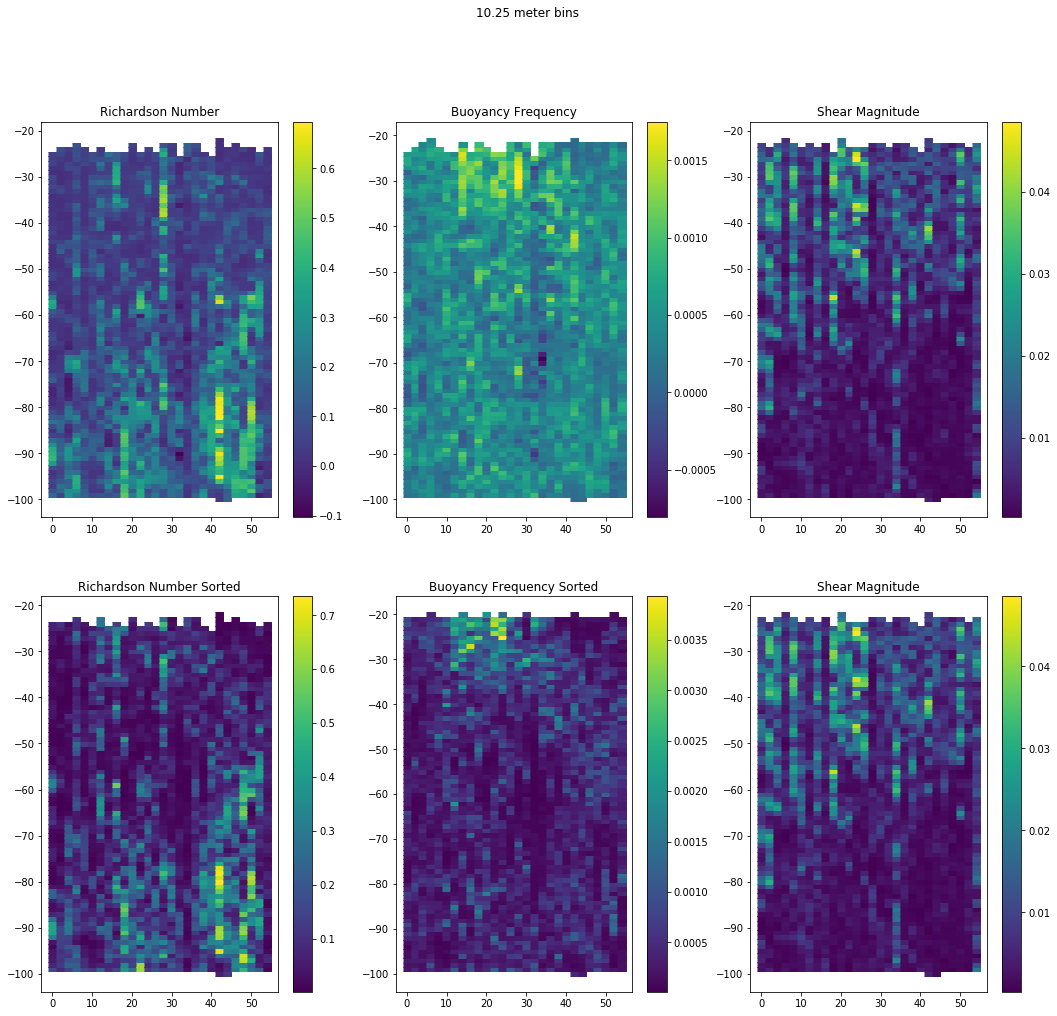

In [83]:
#xi,yi = np.meshgrid(np.arange(0,56,0.5),np.arange(-120,-30,0.5))
#grid_N2 = griddata((grid['profile'],grid["c_depth"]),grid['N2'],(xi,yi),method='linear')
#grid_S2 = griddata((grid['profile'],grid["c_depth"]),grid['S2'],(xi,yi),method='linear')
#grid_Ri = griddata((grid['profile'],grid["c_depth"]),grid['Ri'],(xi,yi),method='linear')

#grid_N2_sort = griddata((grid['profile'],grid["c_depth"]),grid['N2_sort'],(xi,yi),method='linear')
#grid_Ri_sort = griddata((grid['profile'],grid["c_depth"]),grid['Ri_sort'],(xi,yi),method='linear')

ssize =70
v_val=0.5
h_val=1
verts = list(zip([-h_val,h_val,h_val,-h_val],[-v_val,-v_val,v_val,v_val]))

fig, axes = plt.subplots(2,3,figsize=(18, 16))

im1 = axes[0,0].scatter(grid['profile'],grid["c_depth"],c=grid['Ri'], s = ssize,marker=(verts,0))
axes[0,0].set_title('Richardson Number')
im2 = axes[0,1].scatter(grid['profile'],grid["c_depth"],c=grid['N2'],s = ssize,marker=(verts,0))
axes[0,1].set_title('Buoyancy Frequency')
im3 = axes[0,2].scatter(grid['profile'],grid["c_depth"],c=grid['S2'],s =ssize,marker=(verts,0))
axes[0,2].set_title('Shear Magnitude')
fig.colorbar(im1, ax = axes[0,0])
fig.colorbar(im2, ax = axes[0,1])
fig.colorbar(im3, ax = axes[0,2])


im4 = axes[1,0].scatter(grid['profile'],grid["c_depth"],c=grid['Ri_sort'],s =ssize,marker=(verts,0))
axes[1,0].set_title('Richardson Number Sorted')
im5 = axes[1,1].scatter(grid['profile'],grid["c_depth"],c=grid['N2_sort'],s =ssize,marker=(verts,0))
axes[1,1].set_title('Buoyancy Frequency Sorted')
im6 = axes[1,2].scatter(grid['profile'],grid["c_depth"],c=grid['S2'],s =ssize,marker=(verts,0))
axes[1,2].set_title('Shear Magnitude')
fig.colorbar(im4, ax = axes[1,0])
fig.colorbar(im5, ax = axes[1,1])
fig.colorbar(im6, ax = axes[1,2])
plt.suptitle(ttitle)
plt.show()

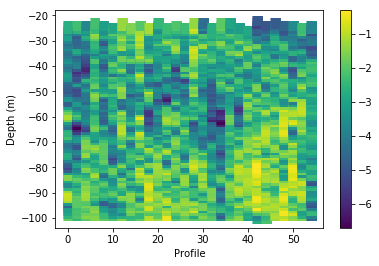

In [84]:
ssize =90
v_val=1
h_val=1
verts = list(zip([-h_val,h_val,h_val,-h_val],[-v_val,-v_val,v_val,v_val]))


plt.scatter(grid['profile'],grid["c_depth"],c=np.log(grid['Ri_sort']),s =ssize,marker=(verts,0))
#plt.scatter(grid['profile'],grid["c_depth"],c=grid['N2_sort'],s =ssize,marker=(verts,0))
#plt.scatter(grid['profile'],grid["c_depth"],c=grid['S2'],s =ssize,marker=(verts,0))
plt.ylabel("Depth (m)")
plt.xlabel("Profile")
plt.colorbar()
#fig.colorbar(im5, ax = axes[1,1])
#fig.colorbar(im6, ax = axes[1,2])
#plt.suptitle(ttitle)
plt.show()